In [518]:
from functools import cmp_to_key

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# set matplotlib backend to inline
%matplotlib inline

# import modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

In [519]:

raw_nhl_data = pd.read_csv('moneypack/all_teams.csv')
columns_to_drop_from_total = ['name', 'gameId', 'playerTeam', 'opposingTeam', 'home_or_away', 'gameDate', 'position',
                              'situation', 'iceTime']
raw_nhl_data = raw_nhl_data.drop(columns=columns_to_drop_from_total)
raw_nhl_data = raw_nhl_data[(raw_nhl_data['season'] != '2023')]

raw_nhl_data_2023 = pd.read_csv('moneypack/all_teams_2023.csv')
raw_nhl_data_2023['playoffGame'] = [0] * len(raw_nhl_data_2023.index)
columns_to_drop_from_2023 = ['games_played', 'name', 'position', 'situation', 'team.1', 'iceTime']
raw_nhl_data_2023 = raw_nhl_data_2023.drop(columns=columns_to_drop_from_2023)

columns_all = raw_nhl_data.columns
columns_2023 = raw_nhl_data_2023.columns

# print(len(raw_nhl_data.columns))
# print(len(raw_nhl_data_2023.columns))

# print(columns_all.difference(columns_2023))
# print(columns_2023.difference(columns_all))

# print(len(raw_nhl_data.values))
# print(len(raw_nhl_data_2023.values))

# print(raw_nhl_data.values)
# print(raw_nhl_data_2023['playoffGame'].values)


by_team_season_all = raw_nhl_data.groupby(['team', 'season']).mean()
by_team_season_all['playoff_qualified'] = by_team_season_all['playoffGame'].apply(lambda val: 1 if val > 0.0 else 0)
#print(by_team_season_all)
# print(type(by_team_season_all))

X = by_team_season_all.drop(columns=['playoff_qualified', 'playoffGame'])
y = by_team_season_all['playoff_qualified']

# Standardize the numerical features using StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# print(pd.DataFrame(X_train_scaled, columns=X.columns).head())


In [520]:
corr_matrix = X.corr().abs()

# Plot the heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(corr_matrix, annot=True, cmap='GnBu', linewidths=0.2, vmin=0, vmax=1)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Importances using Correlation Matrix Heatmap')
plt.show()

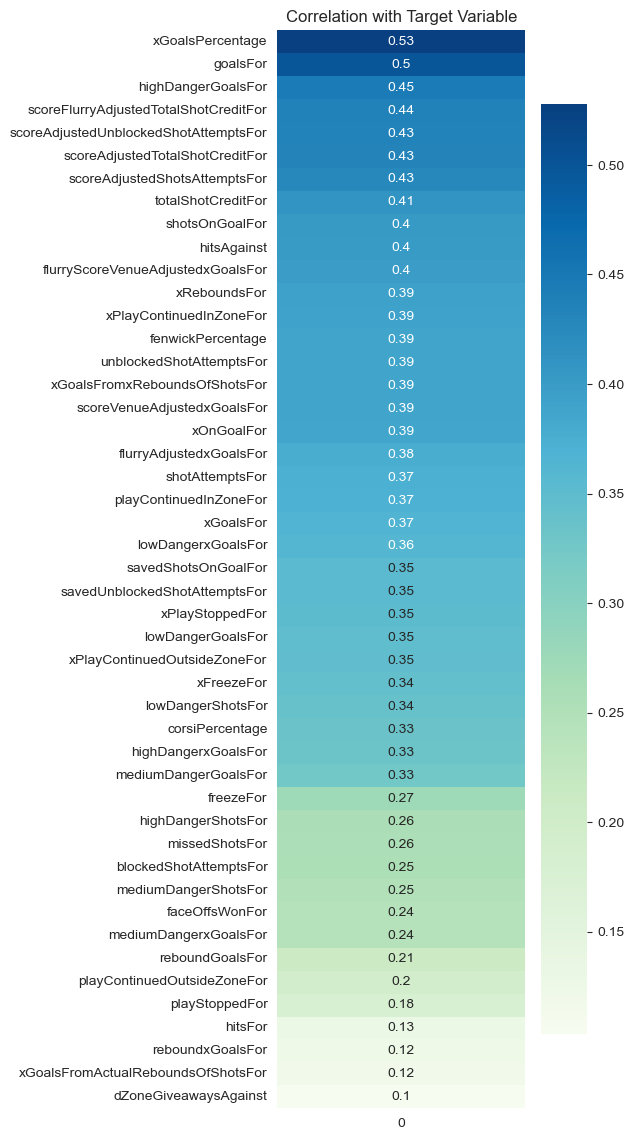

In [521]:

corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target.reset_index(name='score')

# selected_corr_with_target = pd.DataFrame(corr_with_target, columns=['score'])
# selected_corr_with_target.columns = ["feature", "score"]

corr_with_target = corr_with_target.loc[lambda x: x > 0.1]
# print(corr_with_target.index)
# Plot the heatmap
plt.figure(figsize=(4, 14))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
# plt.show()

corr_with_target_frame = pd.DataFrame({"feature": corr_with_target.index, "score": corr_with_target.values})


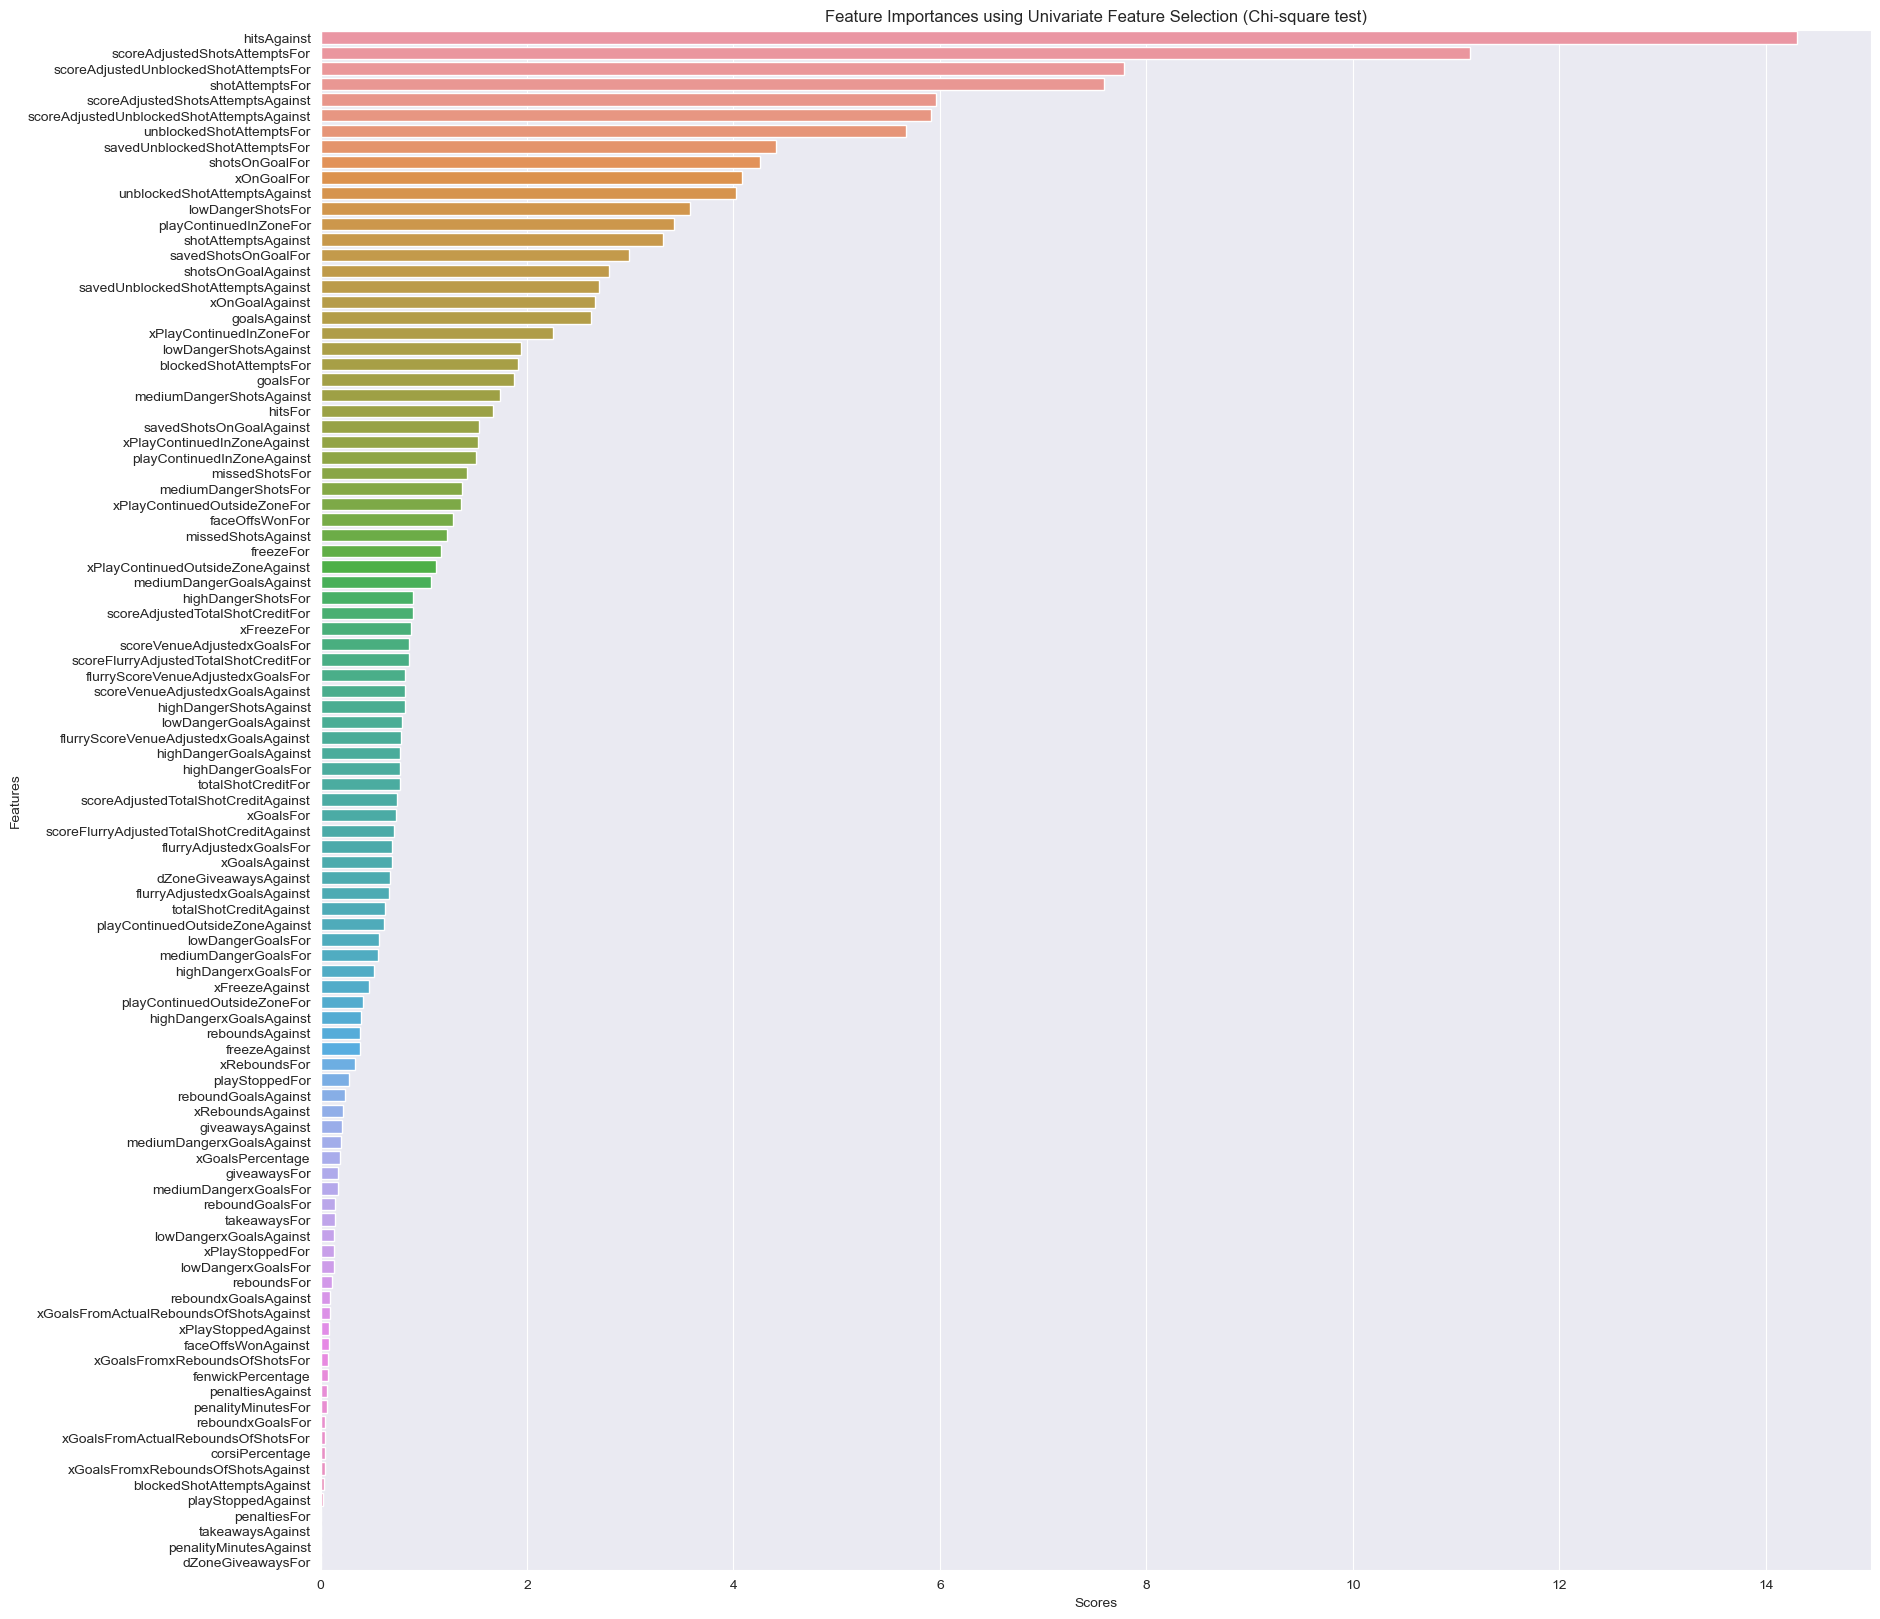

In [522]:

# apply univariate feature selection
best_features = SelectKBest(score_func=chi2, k=5).fit(X, y)

# get the scores and selected features
scores = best_features.scores_
selected_features = X.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(X.columns)[sorted_idxs]

sorted_features_with_scores = pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores})
sorted_features_with_scores = sorted_features_with_scores[sorted_features_with_scores['score'] > 1.0]
# print(sorted_features_with_scores)

# plot scores
plt.figure(figsize=(20, 20))
sns.barplot(x=sorted_scores, y=sorted_feature_names)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
plt.show()

In [523]:
# selected_important_features_data = pd.merge(sorted_features_with_scores, corr_with_target_frame, how ='left', on =['feature'])
selected_important_features_data = sorted_features_with_scores
important_features = selected_important_features_data["feature"].values

In [524]:
X_values = X[important_features].values
y_values = y.values
# X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2)

In [525]:
class MyKNearestNeighborsClassifier:
    pass

    def __init__(self, k):
        self.k = self.__validate_k(k)
        self.x_train = None
        self.y_train = None

    def fit(self, x_train, y_train):
        # np.unique(y) # classes
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        predicted_points = []
        for test_x_point in x_test:
            predicted_points.append(self.__predict_class(test_x_point))
        return np.array(predicted_points)

    def __predict_class(self, x_point):
        distances = []
        # calculate distances to all the training points
        for x_train_point in X_train:
            distances.append(self.__euclidean(x_train_point, x_point))

        nearest_indexes = np.argsort(distances)[:self.k]  # sort distances, take k nearest points' indices
        nearest_classes = self.y_train[nearest_indexes]  # take their classes
        # count number of occurrences of a class and return the index of max counter.
        return np.bincount(nearest_classes).argmax()

    def __euclidean(self, point1, point2):
        distance = np.sum(np.square(point1 - point2))
        return np.sqrt(distance)

    def __validate_k(self, k):
        if k <= 0:
            raise Exception("K cannot be less or equal to zero")

        k += 1  # Ties can be broken consistently by expanding K by 1
        return k

In [526]:
class ModelMetrics:
    def __init__(self, train_x, test_x, train_y, test_y, pred_y, classifier_name):
        self.pred_y = pred_y
        self.train_x = train_x
        self.test_x = test_x
        self.train_y = train_y
        self.test_y = test_y
        self.classifier_name = classifier_name
        self.classes = np.unique(pred_y)
        self.precision = precision_score(test_y, pred_y, average=None)
        self.recall = recall_score(test_y, pred_y, average=None)
        self.accuracy = accuracy_score(test_y, pred_y)
        self.confusion_matrix = confusion_matrix(test_y, pred_y)
        self.f1_score = f1_score(test_y, pred_y)

    def comparator(a, b):
        return a.f1_score - b.f1_score

    def __str__(self):
        return (f'| Classifier  | {self.classifier_name:>23} |\n'
                f'| f1          | {self.f1_score:>23} |\n'
                f'| accuracy    | {self.accuracy:>23} |\n'
                f'| precision   | {self.precision} |\n'
                f'| recall      | {self.recall} |\n'
                # f'conf_matrix: {self.confusion_matrix}'
                )

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.test_y, label='true')
        plt.plot(self.pred_y, label='prediction')
        plt.xlabel(f'Scores of {self.classifier_name}')
        plt.ylabel('Features')
        plt.legend()


class ModelChooser:
    def __init__(self):
        self.data = []

    def push(self, train_x, test_x, train_y, test_y, pred_y, classifier_name):
        self.data.append(ModelMetrics(train_x, test_x, train_y, test_y, pred_y, classifier_name))

    def get_k_best(self, k):
        data = sorted(self.data, key=cmp_to_key(ModelMetrics.comparator), reverse=True)
        return data[:k]


In [527]:
def try_knn(n_neighbors, train_x, train_y, test_x):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    classifier.fit(train_x, train_y)
    return classifier.predict(test_x)


def try_my_knn(n_neighbors, train_x, train_y, test_x):
    classifier = MyKNearestNeighborsClassifier(n_neighbors)
    classifier.fit(train_x, train_y)
    return classifier.predict(test_x)


def try_decision_tree(max_depth, train_x, train_y, test_x):
    classifier = DecisionTreeClassifier(max_depth=max_depth)
    classifier.fit(train_x, train_y)
    return classifier.predict(test_x)


def plot_prediction(test_y, pred_y):
    plt.figure(figsize=(10, 5))
    plt.plot(test_y, label='true')
    plt.plot(pred_y, label='prediction')
    plt.xlabel('Scores')
    plt.ylabel('Features')
    plt.legend()


In [528]:
cvsplt = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
model_chooser = ModelChooser()
for train_index, test_index in cvsplt.split(X_values, y_values):
    X_train, X_test = X_values[train_index], X_values[test_index]
    y_train, y_test = y_values[train_index], y_values[test_index]

    y_pred_knn = try_knn(10, X_train, y_train, X_test)
    y_pred_my_knn = try_my_knn(10, X_train, y_train, X_test)
    y_pred_dec_tree = try_decision_tree(10, X_train, y_train, X_test)

    model_chooser.push(X_train, X_test, y_train, y_test, y_pred_knn, "KNN")
    model_chooser.push(X_train, X_test, y_train, y_test, y_pred_my_knn, "myKNN")
    model_chooser.push(X_train, X_test, y_train, y_test, y_pred_dec_tree, "DecTree")
    


In [529]:
for i, model in enumerate(model_chooser.get_k_best(5)):
    print (f'Model {i+1}')
    print(model)

Model 1
| Classifier  |                 DecTree |
| f1          |       0.851851851851852 |
| accuracy    |      0.8260869565217391 |
| precision   | [0.88235294 0.79310345] |
| recall      | [0.71428571 0.92      ] |

Model 2
| Classifier  |                 DecTree |
| f1          |      0.8461538461538461 |
| accuracy    |      0.8260869565217391 |
| precision   | [0.84210526 0.81481481] |
| recall      | [0.76190476 0.88      ] |

Model 3
| Classifier  |                   myKNN |
| f1          |      0.8333333333333334 |
| accuracy    |      0.8043478260869565 |
| precision   | [0.85294118 0.77586207] |
| recall      | [0.69047619 0.9       ] |

Model 4
| Classifier  |                 DecTree |
| f1          |      0.8247422680412372 |
| accuracy    |      0.8152173913043478 |
| precision   | [0.77777778 0.85106383] |
| recall      | [0.83333333 0.8       ] |

Model 5
| Classifier  |                 DecTree |
| f1          |       0.816326530612245 |
| accuracy    |      0.804347826